### Time-Series Forecasting menggunakan Deep Learning untuk Memprediksi Maintenance mesin Pesawat Terbang

Nama : Ahmad Bisyrul Hafi
NIM : 11180910000122
Program Studi : Teknik Informatika
Fakultas Sains dan Teknologi
UIN Syarif Hidayatullah Jakarta

Pada Project ini kita akan memprediksi kapan mesin dan komponen pada pesawat terbang harus mendapatkan perawatan/maintenance menggunakan Algoritma Machine learning dan Deep Learning.

Project ini ditujukan untuk memenuhi nilai Praktek kerja lapangan dan untuk membuat laporan praktek kerja lapangan

In [8]:
# Import Library yang dibutuhkan untuk membaca datasets
import os
import pandas as pd

# import datasets yang ada menggunakan library pandas
df_tele = pd.read_csv('D:\My Resume\Praktek Kerja Lapangan GMF AeroAsia\Laporan PKL\Project Laporan\Datasets\PdM_telemetry.csv')
df_fail = pd.read_csv('D:\My Resume\Praktek Kerja Lapangan GMF AeroAsia\Laporan PKL\Project Laporan\Datasets\PdM_failures.csv')
df_err = pd.read_csv('D:\My Resume\Praktek Kerja Lapangan GMF AeroAsia\Laporan PKL\Project Laporan\Datasets\PdM_errors.csv')
df_maint = pd.read_csv('D:\My Resume\Praktek Kerja Lapangan GMF AeroAsia\Laporan PKL\Project Laporan\Datasets\PdM_maint.csv')


In [9]:
#print 5 data teratas dari failure dataframe
df_fail.head(n=5)

,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4


Untuk memudahkan kita dalam melakukan analisis kita akan memilih salah satu mesin yang akan kita gunakan untuk melakukan analisis, disini kita akan memilih mesin ke 11

In [10]:
df_sel = df_tele.loc[df_tele['machineID'] == 11].reset_index(drop=True)
df_sel.head(n=5) #menunjukkan index pemakaian 5 jam pertama pada mesin tersebut

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,11,164.039259,389.699577,113.619975,29.775109
1,2015-01-01 07:00:00,11,180.325510,409.788550,97.506203,40.512160
2,2015-01-01 08:00:00,11,146.917119,420.626012,97.087205,33.420937
3,2015-01-01 09:00:00,11,164.895416,426.409611,86.494413,40.263365
4,2015-01-01 10:00:00,11,174.330072,471.774231,109.277816,39.931749


pada output diatas kita akan melihat pemakaian dari mesin yang kita pilih mulai dari TimeStamp dari status voltase, rotasi, tekanan dan getaran pada mesin. 

selanjutnya kita akan mengecek error dan failure record dan akan kita pilih data yang hanya menunjukkan catatan (record) yang hanya dimiliki oleh mesin nomor 11

In [11]:
#cek failure record dari mesin nomor 11
sel_fail = df_fail.loc[df_fail['machineID'] == 11]
pd.DataFrame(sel_fail)

,datetime,machineID,failure
58,2015-01-20 06:00:00,11,comp2
59,2015-02-19 06:00:00,11,comp3
60,2015-04-20 06:00:00,11,comp2
61,2015-04-20 06:00:00,11,comp3
62,2015-10-02 06:00:00,11,comp3
63,2015-12-16 06:00:00,11,comp3


In [12]:
#cek error record dari mesin nomor 11
sel_err = df_err.loc[df_err['machineID'] == 11]
pd.DataFrame(sel_err).head()

,datetime,machineID,errorID
360,2015-01-19 06:00:00,11,error2
361,2015-01-19 06:00:00,11,error3
362,2015-02-15 01:00:00,11,error4
363,2015-02-18 06:00:00,11,error4
364,2015-02-26 23:00:00,11,error4


perbedaan antara error dan failure adalah bahwa error mengacu pada peristiwa yang tidak memerlukan penggantian pada mesin atau komponen, melainkan hanya memerlukan kalibrasi ulang terhadap komponen tersebut.
sedangkan failure mengacu pada peristiwa yang menyebabkan mesin gagal bekerja.

lalu, kita akan melihat dalam alur kronologis bagaimana kedua peristiwa tersebut (error&failure) mempunyai hubungan satu sama lain.

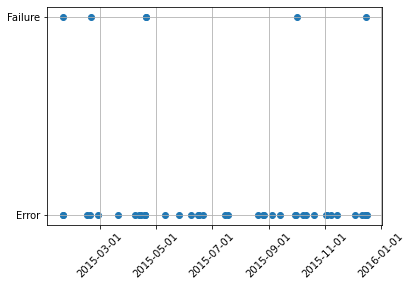

In [13]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots()

# untuk menyederhanakan plot, kita akan menggunakan 2 value yang berbeda di y-axis untuk membedakan antara error dan failure
y_category = list()

for iter in range (0, len(sel_fail)):
    y_category.append('Failure')

for iter in range (0, len(sel_err)):
    y_category.append('Error')

# kita bisa mendapatkan timestamp dari error dan selected failure
df_timestamp = pd.concat([sel_fail['datetime'], sel_err['datetime']], ignore_index=True, axis=0)
df_plot = pd.DataFrame({"timestamp": df_timestamp, "category": y_category})
df_plot.loc[:, 'timestamp'] = pd.to_datetime(df_plot.loc[:, 'timestamp'])
df_plot.sort_values(by=['timestamp'], inplace=True, ignore_index=True)

# plot kan data dengan timestamp sebagai x-axis
ax.scatter('timestamp', 'category', data = df_plot)
yearfmt = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(yearfmt)
ax.tick_params(axis='x', rotation=45)
ax.grid()

### Feature Check

#### Cek Keabnormalan dari Voltase dan Rotasi mesin 

Text(0, 0.5, 'Rotation')

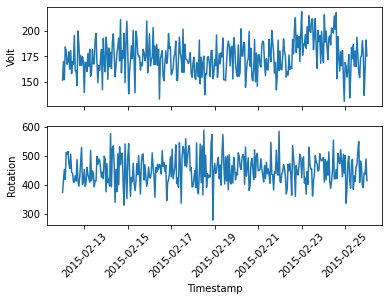

In [14]:
# ubah tipe data pada kolom timestamp dari object menjadi datetime
df_sel.loc[:, 'datetime'] = pd.to_datetime(df_sel.loc[:, 'datetime'])

# Pilih tanggal mana yang ingin kita cek dalam record failure
st = df_sel.loc[df_sel['datetime'] == "2015-02-19"].index.values[0]

# lalu, filter data telemetri berdasarkan tanggal dan masukkan juga data 7 hari dan sesudahnya
# error terjadi untuk mengamati ke abnormalan apapun pada data.
select = df_sel.loc[st-7*24:st + 7*24,:]

# plot kan voltase dan fitur rotasi
fig, ax = plt.subplots(nrows=2, sharex=True)
ax[0].plot('datetime', 'volt', data=select)
ax[0].set_ylabel("Volt")

ax[1].plot('datetime', 'rotate', data=select)
ax[1].tick_params(axis='x', rotation=45)
ax[1].set_xlabel("Timestamp")
ax[1].set_ylabel("Rotation")

saat kita mengamati pembacaan voltase dan rotasi diatas, tidak ada anomali yang terlihat di sekitar periode 2015-02-19. kemudian, selanjutnya kita akan memeriksa fitur tekanan dan getaran dengan membuat plot.

#### Cek Keabnormalan dari Pressure dan Vibration

Text(0, 0.5, 'Vibration')

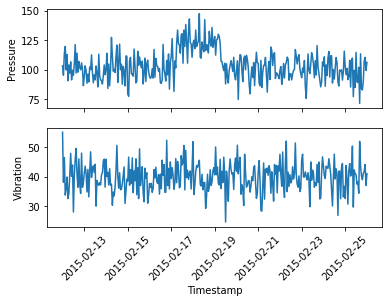

In [15]:
# plot pressure dan vibration feature
fig, ax = plt.subplots(nrows=2, sharex =True)
ax[0].plot('datetime', 'pressure', data=select)
ax[0].set_ylabel("Pressure")

ax[1].plot("datetime", 'vibration', data=select)
ax[1].tick_params(axis='x', rotation=45)
ax[1].set_xlabel("Timestamp")
ax[1].set_ylabel("Vibration")

pada feature check pressure dan vibration, terlihat bahwa adanya abnomality yang sangat jelas pada periode 2015-02-19, setelah terlihat adanya abnormality pada pressure dan vibration, kita bisa menggunakannya sebagai feature dan predictor.

#### Check Autocorrelation and Partial Autocorrelation

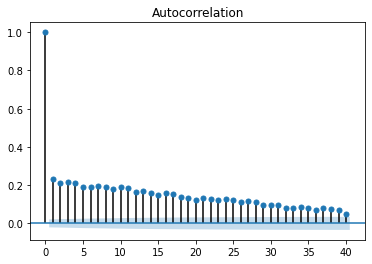

In [16]:
# Import plotting function
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Autocorrelation plot
plot_acf(df_sel['pressure'], lags = 40)
plt.show()

Dari autocorrelation plot terlihat bahwa data berkorelasi positif hingga lag 40, dimana autocorrelation value nya sendiri cukup rendah, hal ini menunjukkan bahwa data tersebut tidak memiliki sifat autokorelasi yang kuat.

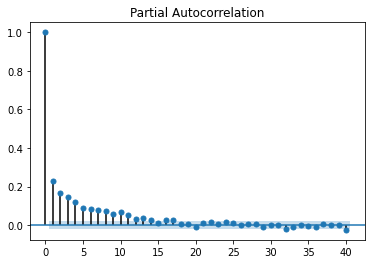

In [17]:
# partial autocorrelation plot
plot_pacf(df_sel['pressure'], lags = 40)
plt.show()

Dari partial autocorrelation plot, korelasi antara nilai dari dua titik waktu yang berbeda juga cukup lemah, menurun ke nol mulai dari lag ke-15. Informasi ini akan digunakan dalam menentukan lag dalam model yang akan kita buat.

### Model Selection

#### Siapkan input dan output data

pada project ini kita akan menggunakan LSTM Model (Long-Short Term Memory) model ini biasa digunakan untuk time-series forecasting, untuk menggunakan LSTM model, kita perlu menyediakan input dan output data dengan format yang benar.

untuk project ini, kita akan menggunakan training data dari 1 bulan historical data yang berisi data pada periode 2015-02-19 tanggal dimana kegagalan pada mesin terjadi untuk memprediksi kegagalan lain yang terjadi pada 2015-04-20 sesuai dengan yang tertulis pada historical data yang ada. fitur yang akan kita gunakan disini adalah pressure reading dan timestamp (one-hot-encoded).

In [19]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# pilih data yang diinginkan untuk mengecek failure records
st_train = df_sel.loc[df_sel['datetime'] == "2015-02-19"].index.values[0]

#filter data untuk menyertakan kira-kira 1 bulan pertama
start_period = st_train - 14*24
end_period = st_train + 14*24

def create_feature(start,end):
    # membuat feature dari mesin yang kita pilih
    pressure = df_sel.loc[start: end, 'pressure']
    timestamp = pd.to_datetime(df_sel.loc[start: end, 'datetime'])
    timestamp_hour = timestamp.map(lambda x: x.hour)
    timestamp_dow = timestamp.map(lambda x: x.dayofweek)
    
    # penerapan one-hot encode untuk timestamp data
    timestamp_hour_onehot = pd.get_dummies(timestamp_hour).to_numpy()
    
    # penerapan skala min-max ke numerical data
    scaler = MinMaxScaler()
    pressure = scaler.fit_transform(np.array(pressure).reshape(-1,1))
    
    # penggabungan fitur menjadi satu
    feature = np.concatenate([pressure, timestamp_hour_onehot],axis=1)
    
    X = feature[:-1]
    y = np.array(feature[5:,0]).reshape(-1,1)
    
    return X, y, scaler

X, y, pres_scaler = create_feature(start_period, end_period)



setelah itu, kita perlu membentuk input ke dalam urutan (array numpy 3 dimensi). kita akan menggunakan fungsi untuk mengembalikan urutan input dan output dimana setiap urutan input terdiri dari 5 titik pengamatan (Observation Point). sederhananya, pengamatan 5 jam terakhir akan kita gunakan untuk memprediksi pembacaan sensor pada 1 jam berikutnya.

In [20]:
def shape_sequence(arr, step, start):
    out = list()
    for i in range(start, arr.shape[0]):
        low_lim = i
        up_lim = low_lim + step
        out.append(arr[low_lim: up_lim])
        
        if up_lim == arr.shape[0]:
            #print (i)
            break
    out_seq = np.array(out)
    return out_seq

# bentuk sequence (urutan) sesuai dengan panjang yang ditentukan
X_seq = shape_sequence(X, 5, 0)
y_seq = shape_sequence(y, 1, 0)

# pisahkan input dan output untuk pelatihan dan validasi
X_train, X_val, y_train, y_val = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

print("Training data shape = ", X_train.shape)
print("Validation data shape = ", X_val.shape)

Training data shape =  (534, 5, 25)
Validation data shape =  (134, 5, 25)


### Pembuatan model Prediksi 

kita akan membuat 2 layer LSTM model menggunakan input shape yang cocok dengan shape yang ada di data sequence yang disediakan

In [24]:
# from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow.keras.losses as loss

def create_model(X_train, y_train):
    shape = X_train.shape[1]
    feat_length = X_train.shape[2]
    
    model = Sequential()
    model.add(LSTM(shape, activation='tanh', input_shape=(shape, feat_length), return_sequences=True))
    model.add(LSTM(shape, activation='tanh', input_shape=(shape, feat_length), return_sequences=False))
    model.add(Dense(shape, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=Adam(lr=0.035), loss=loss.mean_squared_error)
    model.fit(X_train, y_train, verbose=1, epochs=500)

    return model

model = create_model(X_train, y_train)

Epoch 1/500
17/17 [==============================] - 0s 8ms/step - loss: 0.0446
Epoch 2/500
17/17 [==============================] - 0s 8ms/step - loss: 0.0238
Epoch 3/500
17/17 [==============================] - 0s 11ms/step - loss: 0.0218
Epoch 4/500
17/17 [==============================] - 0s 14ms/step - loss: 0.0218
Epoch 5/500
17/17 [==============================] - 0s 13ms/step - loss: 0.0223
Epoch 6/500
17/17 [==============================] - 0s 11ms/step - loss: 0.0222
Epoch 7/500
17/17 [==============================] - 0s 8ms/step - loss: 0.0223
Epoch 8/500
17/17 [==============================] - 0s 8ms/step - loss: 0.0209
Epoch 9/500
17/17 [==============================] - 0s 10ms/step - loss: 0.0199
Epoch 10/500
17/17 [==============================] - 0s 8ms/step - loss: 0.0185
Epoch 11/500
17/17 [==============================] - 0s 12ms/step - loss: 0.0199: 0s - loss: 0.020
Epoch 12/500
17/17 [==============================] - 0s 13ms/step - loss: 0.0176
Epoch 13/500

#### Validasi hasil training

kita akan mengecek valid atau tidaknya performa model dengan data validation 

Validation error =  0.025327925


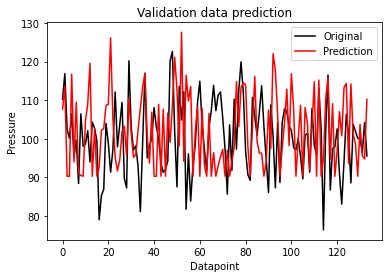

In [25]:
# prediksi validasi data menggunakan model yang sudah dilatih
y_pred = model.predict(X_val)
mse = MeanSquaredError()
val_err = mse(y_val.reshape(-1, 1), y_pred)
print("Validation error = ", val_err.numpy())

# Return value nya menggunakan inverse transform untuk memungkinkan mendapatkan pengamatan yang lebih baik
plt.plot(pres_scaler.inverse_transform(y_val.reshape(-1,1)),'k', label='Original')
plt.plot(pres_scaler.inverse_transform(y_pred.reshape(-1,1)),'r', label='Prediction')
plt.ylabel("Pressure")
plt.xlabel("Datapoint")
plt.title("Validation data prediction")
plt.legend()
plt.show()

### Cek hasil pengujian

Dari plot, kita dapat melihat bahwa beberapa titik data tidak akurat, yang dapat disebabkan oleh sifat titik data per jam yang sangat berfluktuasi. Selanjutnya, kita akan melihat apakah model dapat memprediksi pembacaan sensor dengan benar jika terjadi anomali. Kita akan memilih tanggal lain di mana kegagalan terjadi (2015-04-20). 

Testing error =  0.039613742


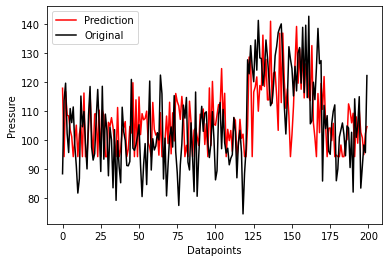

In [26]:
# pilih tanggal kapan terjadinya failure (kegagalan) lainnya
st_test = df_sel.loc[df_sel['datetime'] == "2015-04-20"].index.values[0]

# Selanjutnya, filter data untuk menyertakan kira-kira 2 minggu pertama pada data
start_period_test = st_test - 7*24
end_period_test = st_test + 7*24
X_test, y_test, test_scaler = create_feature(start_period_test, end_period_test)

# Bentuk Sequence
X_test_seq = shape_sequence(X_test, 5, 0)
y_test_seq = shape_sequence(y_test, 1, 0)

# Prediksi data Pengujian
y_pred_test = model.predict(X_test_seq)
test_err = mse(y_test_seq.reshape(-1,1), y_pred_test)
print("Testing error = ", test_err.numpy())

# pilih 200 datapoints pertama untuk memungkinkan model menghasilkan plotting yang lebih baik.
# Return Valuenya menggunakan inverse transform untuk memungkinka kita mendapatkan observasi (pengamatan) yang lebih baik.
plt.plot(test_scaler.inverse_transform(y_pred_test[:200].reshape(-1, 1)), 'r', label='Prediction')
plt.plot(test_scaler.inverse_transform(y_test_seq[:200].reshape(-1, 1)), 'k', label='Original')
plt.ylabel("Pressure")
plt.xlabel("Datapoints")
plt.legend()
plt.show()

Penulis mengamati bahwa model dapat memprediksi pembacaan sensor bahkan jika terjadi kegagalan mesin. untuk mendapatkan hasil tersebut, hal yang sangat penting di sini adalah memastikan bahwa data pelatihan yang kita gunakan untuk melatih menyertakan event failure (kegagalan) masa lalu atau historical failure.

## Further Steps

Sekarang kita tahu bagaimana membangun model peramalan deret waktu untuk memprediksi anomali, ada beberapa langkah yang mungkin tentang cara mengembangkan solusi predictive maintenance yang sempurna:

1) Kembangkan model machine learning / Deep Learning untuk memprediksi kemungkinan kerusakan mesin dengan memasukkan hasil prediksi dari time-series forecasting yang telah dikembangkan sebelumnya.

2) lihat ke dalam Signal processing algorithm untuk menjernihkan sinyal sebelum memasukkannya ke time-series forecasting model, yang dapat meningkatkan kinerja model.

3) Gunakan subset data yang lebih besar dalam proses pelatihan dan periksa bagaimana model berubah, apakah menjadi lebih baik atau lebih buruk?

4) Lakukan optimasi hyperparameter untuk lebih mengoptimalkan kinerja time-series forecasting model

## Kesimpulan

kita telah membangun time-series forecasting model yang akan memprediksi nilai pembacaan sensor di masa mendatang. sehingga kita sebagai engineer bisa menyiapkan equipment pengganti yang dibutuhkan sebelum masa penggunaan dari equipment sebelum nya habis, hal ini bisa meningkatkan availability atau ketersediaan dari equipment tersebut yang dapat mempercepat perbaikan pada pesawat terbang.